In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd 

import os
import matplotlib.pyplot as plt

import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

/Users/quentinbacquele/Desktop/PhD/analysis/mps/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
metadata = np.load('../data/metadata_500ms.npz', allow_pickle=True)
MPS = np.load('../data/X_500ms.npy', allow_pickle=True)

In [3]:
lengths = np.array([len(subarr) for subarr in MPS])
min_length = lengths.min()
max_length = lengths.max()
mean_length = lengths.mean()
median_length = np.median(lengths)
std_length = lengths.std()

print(f"Min length: {min_length}")
print(f"Max length: {max_length}")
print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length}")
print(f"Standard Deviation: {std_length:.2f}")

Min length: 9898
Max length: 10201
Mean length: 9898.02
Median length: 9898.0
Standard Deviation: 2.51


In [4]:
expected_length = 9898

valid_indices = []
filtered_mps = []

for i, mps in enumerate(MPS):
    if len(mps) == expected_length:
        filtered_mps.append(mps)
        valid_indices.append(i)

print(f"Removed {len(MPS) - len(filtered_mps)} outlier(s) out of {len(MPS)}")

Removed 8 outlier(s) out of 116800


In [5]:
MPS = np.stack(filtered_mps)
print("Shape of standardized MPS array:", MPS.shape)

Shape of standardized MPS array: (116792, 9898)


In [6]:
metadata_dict = {key: metadata[key] for key in metadata.files}

metadata_df = pd.DataFrame(metadata_dict)
metadata_df.head()

,gen,family,species,sub_species,common_name,recordist,date,time,country,location,lat,lng,bird,filename
0,Turdinus,Pellorneidae (Ground Babblers and Allies),Turdinus atrigularis,None,Black-throated Wren-Babbler,Somkiat Pakapinyo (Chai),2019-07-27,06:30,Malaysia,"Danum Valley Field Centre, Danum Valley, Sabah...",4.9634,117.8028,495996,Turdinus_atrigularis_495996_seg6.wav
1,Sipia,Thamnophilidae (Typical Antbirds),Sipia palliata,None,Magdalena Antbird,Bram Vogels,2021-12-11,08:00,Colombia,"San Francisco, Antioquia",5.8938,-74.8565,694258,Sipia_palliata_694258_seg11.wav
2,Eurillas,Pycnonotidae (Bulbuls),Eurillas virens,erythroptera,Little Greenbul,Étienne Leroy,2020-01-10,12:00,Ivory Coast,"Forêt classée du Mont Tonkoui, Man, Montagnes ...",7.4498,-7.6382,533334,Eurillas_virens_533334_seg10.wav
3,Geothlypis,Parulidae (New World Warblers),Geothlypis tolmiei,None,MacGillivray's Warbler,Bruce Lagerquist,2022-06-13,09:59,United States,"Old Blewitt Pass, Kittitas County, Washington",47.3483,-120.6754,762298,Geothlypis_tolmiei_762298_seg2.wav
4,Lathrotriccus,Tyrannidae (Tyrant Flycatchers),Lathrotriccus euleri,bolivianus,Euler's Flycatcher,Nick Athanas,2002-06-21,07:00,Ecuador,"El Para, east of Archidona, Napo",-0.952,-77.7314,8091,Lathrotriccus_euleri_8091_seg4.wav


In [7]:
metadata_df = metadata_df.iloc[valid_indices].reset_index(drop=True)
metadata_df['species'] = metadata_df['filename'].apply(lambda x: '_'.join(x.split('_')[:2]))

In [8]:
species_counts = metadata_df['species'].value_counts()
metadata_df['weights'] = metadata_df['species'].map(species_counts)
metadata_df['weights'] = 1.0 / metadata_df['weights']

In [9]:
n_samples, n_features = MPS.shape

print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 116792
Number of features: 9898


In [10]:
data_matrix = MPS.astype(np.float32)
weights = np.array(metadata_df['weights'].values, dtype=np.float32)

In [11]:
cov_matrix = (data_matrix.T * weights) @ data_matrix / np.sum(weights)

/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_17857/1870410875.py:1: RuntimeWarning: divide by zero encountered in matmul
  cov_matrix = (data_matrix.T * weights) @ data_matrix / np.sum(weights)
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_17857/1870410875.py:1: RuntimeWarning: overflow encountered in matmul
  cov_matrix = (data_matrix.T * weights) @ data_matrix / np.sum(weights)
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_17857/1870410875.py:1: RuntimeWarning: invalid value encountered in matmul
  cov_matrix = (data_matrix.T * weights) @ data_matrix / np.sum(weights)


In [12]:
from numpy.linalg import eig

# Eigendecomposition of covariance matrix
eig_vals, eig_vecs = eig(cov_matrix)
eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs = eig_vecs*signs[np.newaxis,:]
eig_vecs = eig_vecs.T

In [13]:
# We first make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

# Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

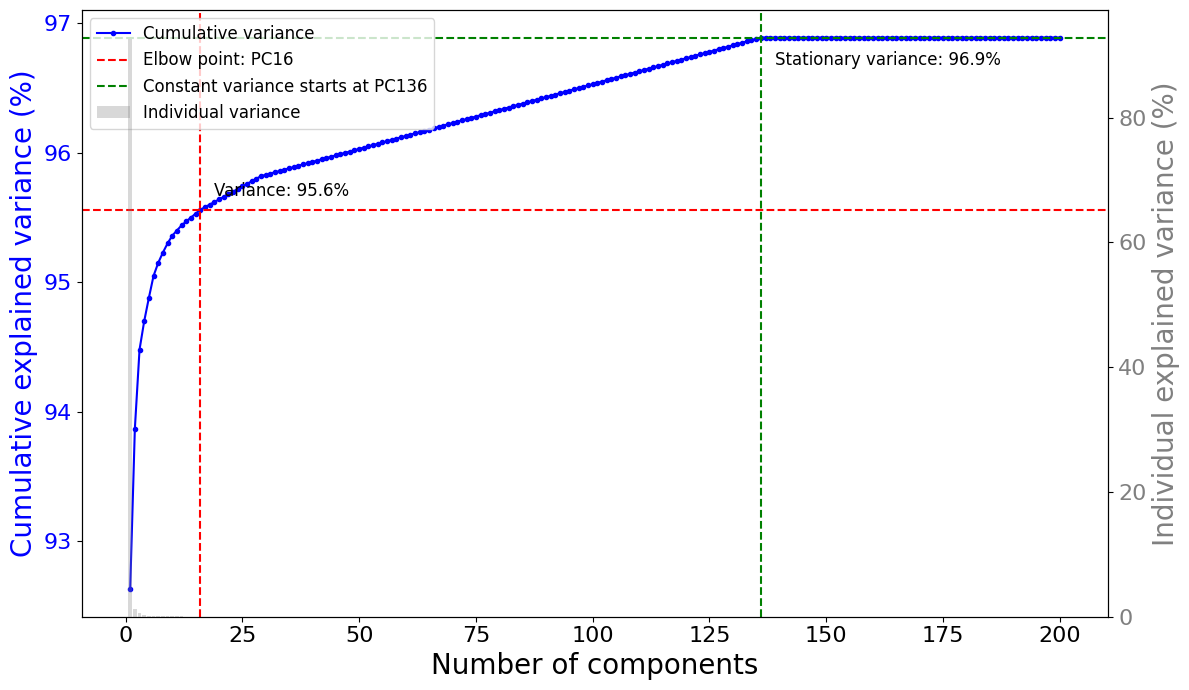

Elbow point occurs at PC16 with 95.6% cumulative explained variance
Cumulative variance becomes nearly constant at PC136 with 96.9% variance


In [14]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

# Assuming eig_vals and eig_vals_sorted are already computed
eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

# Limit to first 200 components
n_components = 200
x = np.arange(1, n_components+1)
explained_variance_truncated = explained_variance[:n_components]
cum_explained_variance_truncated = cum_explained_variance[:n_components]

# Find the elbow point using truncated data
kneedle = KneeLocator(
    x, 
    cum_explained_variance_truncated, 
    S=1,
    curve="concave", 
    direction="increasing"
)
elbow_point = kneedle.knee

# Find the point where cumulative variance stops increasing significantly
# Here, we look for the first instance where the increment is less than a threshold
increment_threshold = 0.001  # adjust threshold (in percentage points) as needed
diffs = np.diff(cum_explained_variance_truncated)
constant_indices = np.where(diffs < increment_threshold)[0]

if constant_indices.size > 0:
    constant_point = constant_indices[0] + 1  # shift index because of np.diff
    constant_variance = cum_explained_variance_truncated[constant_point-1]
else:
    constant_point = None

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()

# Plot cumulative variance on primary y-axis
line1 = ax1.plot(x, cum_explained_variance_truncated, '-o', color='blue', 
                 label='Cumulative variance', markersize=3)
ax1.set_xlabel('Number of components', fontsize=20)
ax1.set_ylabel('Cumulative explained variance (%)', fontsize=20, color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)

# Plot histogram of individual variances on secondary y-axis
bars = ax2.bar(x, explained_variance_truncated, alpha=0.3, color='gray', 
               label='Individual variance')
ax2.set_ylabel('Individual explained variance (%)', fontsize=20, color='gray')
ax2.tick_params(axis='y', labelcolor='gray', labelsize=16)

# Add vertical line at elbow point
if elbow_point:
    ax1.axvline(x=elbow_point, color='r', linestyle='--', 
                label=f'Elbow point: PC{elbow_point}')
    elbow_variance = cum_explained_variance_truncated[elbow_point-1]
    ax1.axhline(y=elbow_variance, color='r', linestyle='--')
    ax1.annotate(f'Variance: {elbow_variance:.1f}%', 
                 xy=(elbow_point, elbow_variance),
                 xytext=(10, 10), textcoords='offset points',
                 fontsize=12)

# Add second marker when variance stops increasing
if constant_point:
    ax1.axvline(x=constant_point, color='green', linestyle='--', 
                label=f'Constant variance starts at PC{constant_point}')
    ax1.axhline(y=constant_variance, color='green', linestyle='--')
    ax1.annotate(f'Stationary variance: {constant_variance:.1f}%', 
                 xy=(constant_point, constant_variance),
                 xytext=(10, -20), textcoords='offset points',
                 fontsize=12)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

# Remove grid and adjust layout
plt.grid(False)
plt.tight_layout()
plt.show()

if elbow_point:
    print(f"Elbow point occurs at PC{elbow_point} with {elbow_variance:.1f}% cumulative explained variance")
else:
    print("No clear elbow point was found")

if constant_point:
    print(f"Cumulative variance becomes nearly constant at PC{constant_point} with {constant_variance:.1f}% variance")
else:
    print("No point of constant variance was detected")


/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:13: RuntimeWarning: divide by zero encountered in matmul
  pc_scores = (data_matrix - mean_data) @ eig_vecs_sorted.T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:13: RuntimeWarning: overflow encountered in matmul
  pc_scores = (data_matrix - mean_data) @ eig_vecs_sorted.T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:13: RuntimeWarning: invalid value encountered in matmul
  pc_scores = (data_matrix - mean_data) @ eig_vecs_sorted.T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:38: RuntimeWarning: divide by zero encountered in matmul
  reconstruction = (mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]).reshape(98, 101)
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:38: RuntimeWarning: overflow encountered in matmul
  reconstruction = (mean_data + pc_scores[sample_


Sample 80267:
1 PCs reconstruction MSE: 0.551776
2 PCs reconstruction MSE: 0.510687
3 PCs reconstruction MSE: 0.510685
4 PCs reconstruction MSE: 0.492236
5 PCs reconstruction MSE: 0.491746
10 PCs reconstruction MSE: 0.466544
15 PCs reconstruction MSE: 0.463365
25 PCs reconstruction MSE: 0.445528
50 PCs reconstruction MSE: 0.427559
100 PCs reconstruction MSE: 0.401502
136 PCs reconstruction MSE: 0.384398
Full reconstruction MSE: 0.000200

Sample 88351:
1 PCs reconstruction MSE: 0.404270
2 PCs reconstruction MSE: 0.196835
3 PCs reconstruction MSE: 0.195175
4 PCs reconstruction MSE: 0.193907
5 PCs reconstruction MSE: 0.191650
10 PCs reconstruction MSE: 0.169035
15 PCs reconstruction MSE: 0.162532
25 PCs reconstruction MSE: 0.157944
50 PCs reconstruction MSE: 0.148379
100 PCs reconstruction MSE: 0.138304
136 PCs reconstruction MSE: 0.133976
Full reconstruction MSE: 0.000058

Sample 89843:
1 PCs reconstruction MSE: 0.154191
2 PCs reconstruction MSE: 0.145915
3 PCs reconstruction MSE: 0.143

/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:57: RuntimeWarning: divide by zero encountered in matmul
  reconstruction = mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:57: RuntimeWarning: overflow encountered in matmul
  reconstruction = mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:57: RuntimeWarning: invalid value encountered in matmul
  reconstruction = mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:62: RuntimeWarning: divide by zero encountered in matmul
  full_reconstruction = mean_data + pc_scores[sample_idx] @ eig_vecs_sorted
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/3978126810.py:62: RuntimeWarning: overflow encountered in matmul
  

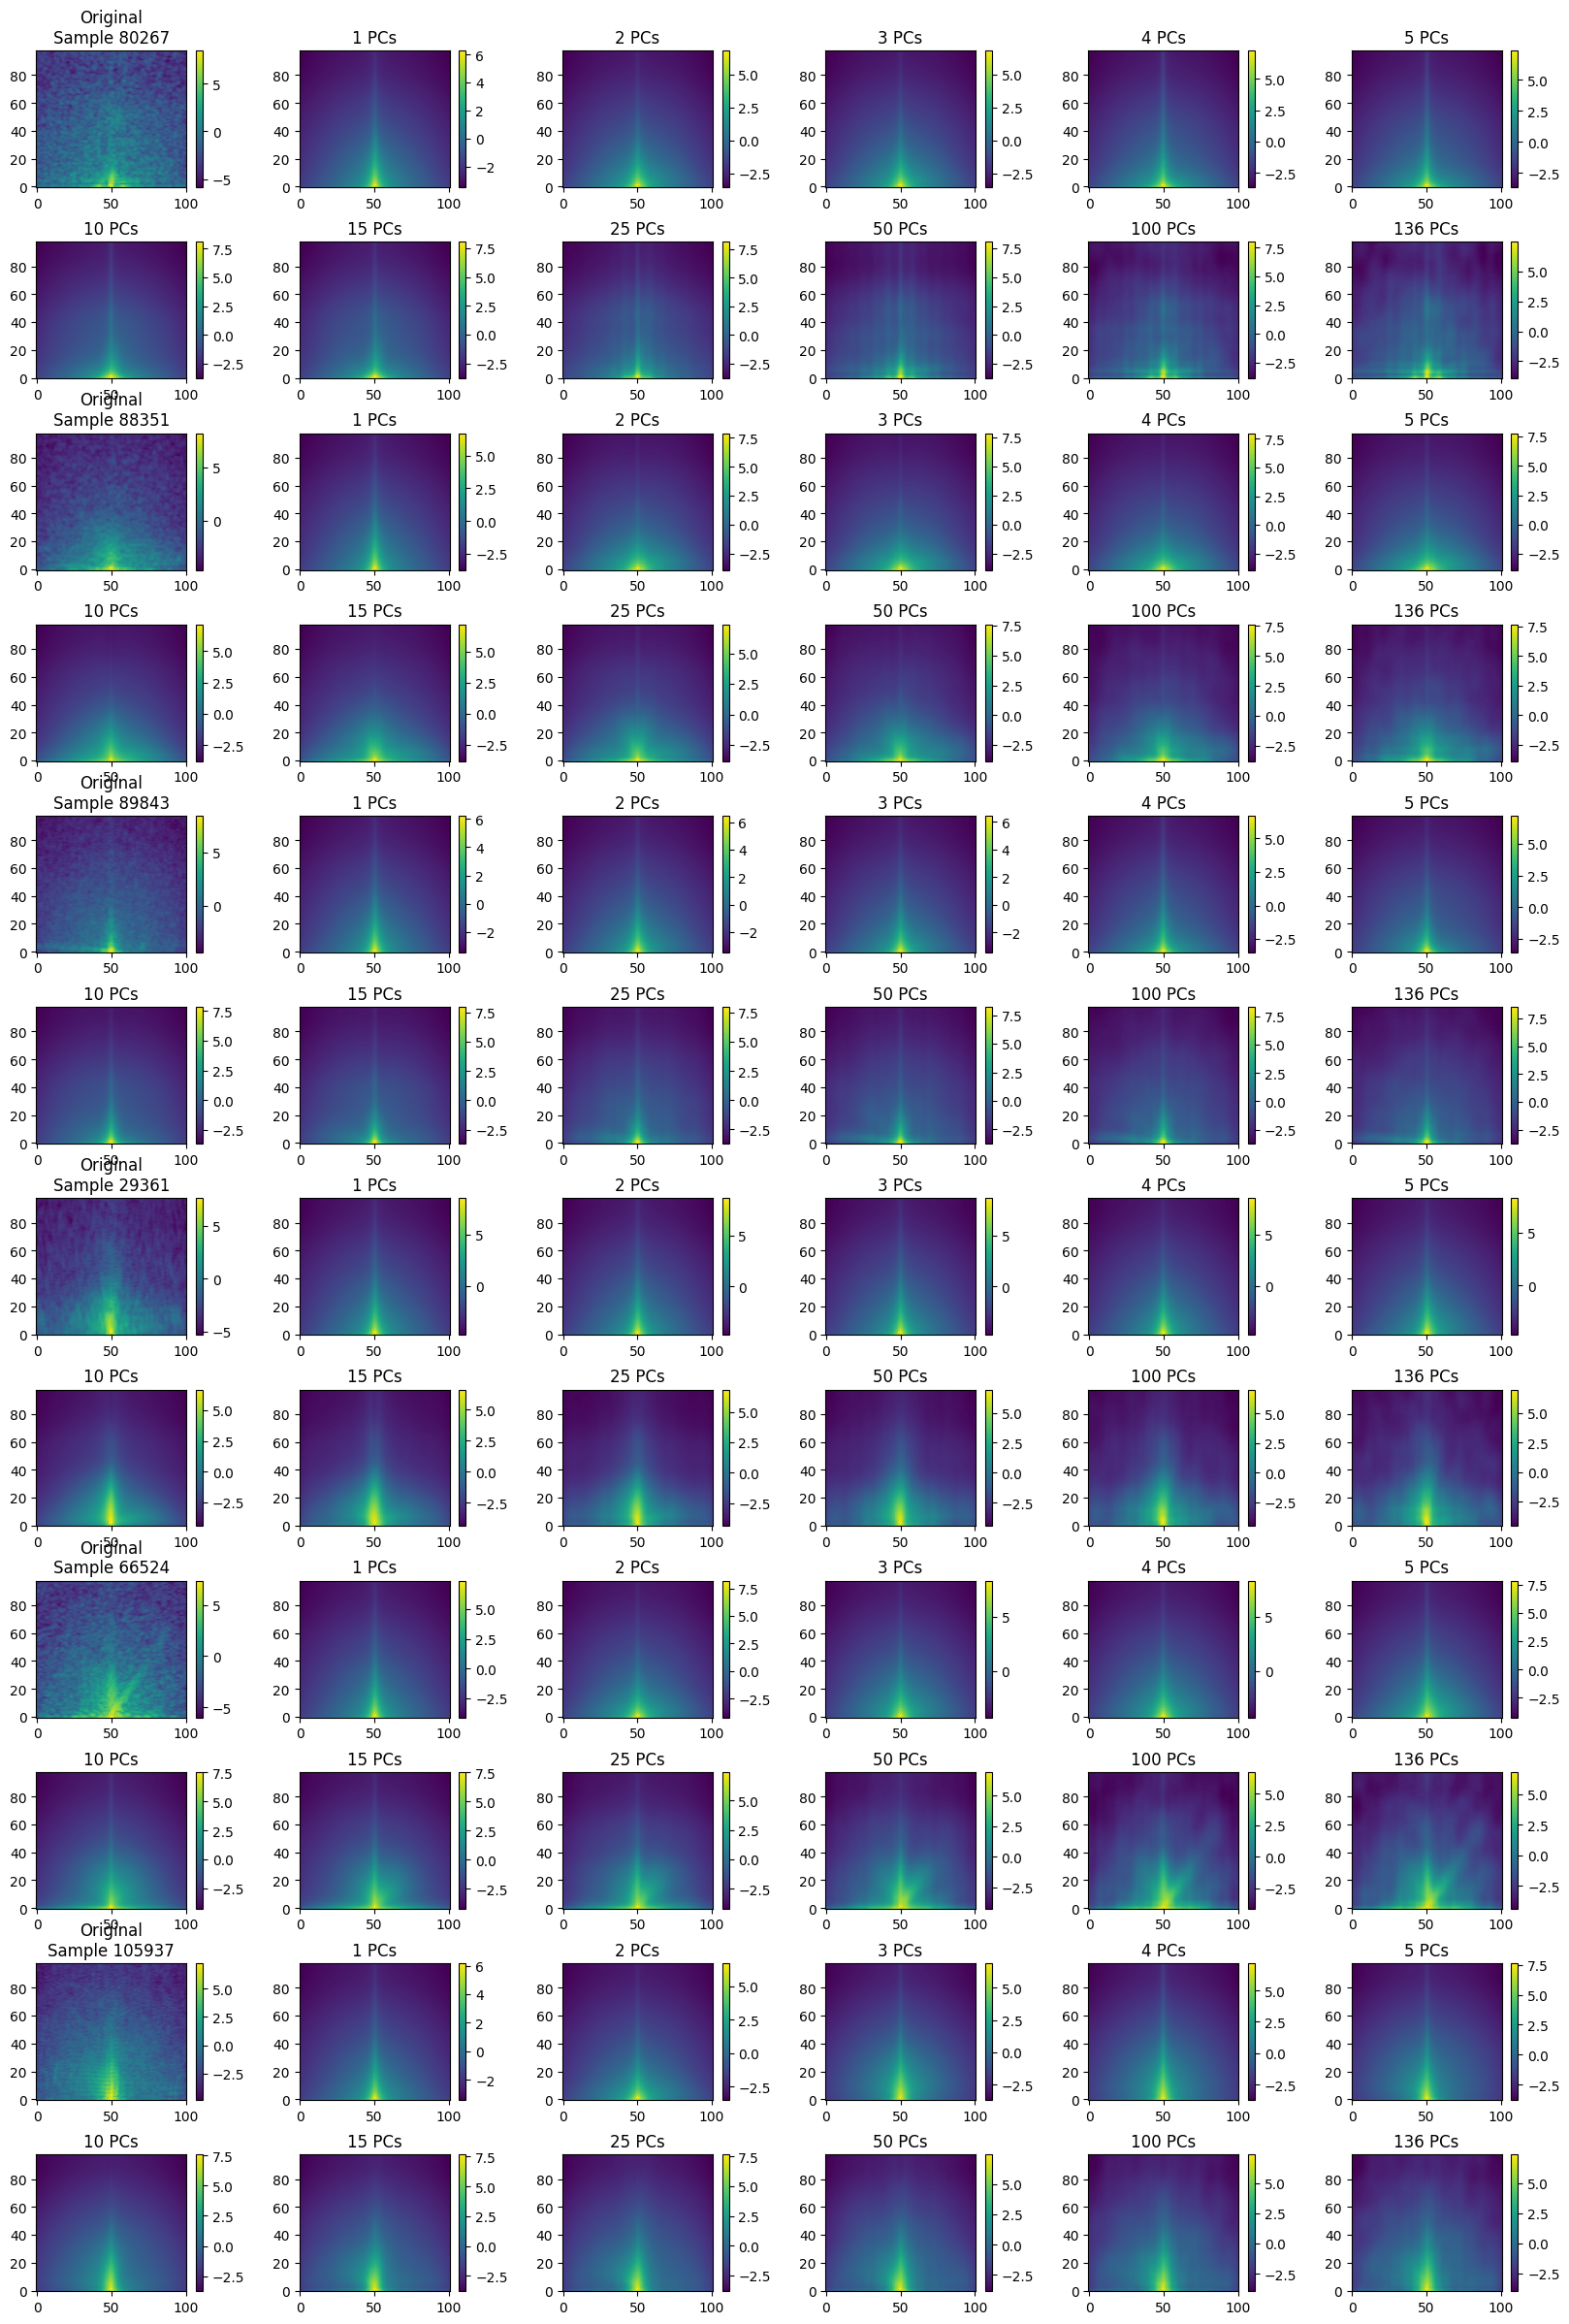

In [15]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)  # for reproducibility

# Select 6 random sample indices
n_samples = data_matrix.shape[0]
random_indices = np.random.choice(n_samples, 6, replace=False)

# Calculate mean of the original data
mean_data = np.average(data_matrix, weights=weights, axis=0)

# Calculate PC scores for all samples
pc_scores = (data_matrix - mean_data) @ eig_vecs_sorted.T

# Define PC numbers to display
pcs_row1 = [1, 2, 3, 4, 5]
pcs_row2 = [10, 15, 25, 50, 100, 136]

# Create figure with subplots for the 6 samples
fig, axes = plt.subplots(12, 6, figsize=(20, 30))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for sample_num, sample_idx in enumerate(random_indices):
   # Get row indices for this sample
   row1_idx = sample_num * 2
   row2_idx = sample_num * 2 + 1
   
   # Original image
   original = data_matrix[sample_idx].reshape(98, 101)
   
   # Plot original in both rows
   im0_1 = axes[row1_idx, 0].imshow(original, aspect='auto', cmap='viridis', origin='lower')
   axes[row1_idx, 0].set_title(f'Original\nSample {sample_idx}')
   plt.colorbar(im0_1, ax=axes[row1_idx, 0])
   
   # First row reconstructions (1-5 PCs)
   for i, n_pc in enumerate(pcs_row1):
       reconstruction = (mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]).reshape(98, 101)
       im = axes[row1_idx, i+1].imshow(reconstruction, aspect='auto', cmap='viridis', origin='lower')
       axes[row1_idx, i+1].set_title(f'{n_pc} PCs')
       plt.colorbar(im, ax=axes[row1_idx, i+1])
       
   # Second row reconstructions (10-136 PCs)
   for i, n_pc in enumerate(pcs_row2):
       reconstruction = (mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]).reshape(98, 101)
       im = axes[row2_idx, i].imshow(reconstruction, aspect='auto', cmap='viridis', origin='lower')
       axes[row2_idx, i].set_title(f'{n_pc} PCs')
       plt.colorbar(im, ax=axes[row2_idx, i])

# Print reconstruction errors
for sample_idx in random_indices:
   print(f"\nSample {sample_idx}:")
   
   # Calculate errors for all PC numbers
   all_pcs = pcs_row1 + pcs_row2
   for n_pc in all_pcs:
       reconstruction = mean_data + pc_scores[sample_idx, :n_pc] @ eig_vecs_sorted[:n_pc]
       error = np.mean((data_matrix[sample_idx] - reconstruction)**2)
       print(f"{n_pc} PCs reconstruction MSE: {error:.6f}")
   
   # Full reconstruction error
   full_reconstruction = mean_data + pc_scores[sample_idx] @ eig_vecs_sorted
   full_error = np.mean((data_matrix[sample_idx] - full_reconstruction)**2)
   print(f"Full reconstruction MSE: {full_error:.6f}")

plt.show()

  0%|          | 0/150 [00:00<?, ?it/s]/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/808829198.py:25: RuntimeWarning: divide by zero encountered in matmul
  batch_scores = (batch_data - mean_data) @ eig_vecs_sorted[:n_comp].T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/808829198.py:25: RuntimeWarning: overflow encountered in matmul
  batch_scores = (batch_data - mean_data) @ eig_vecs_sorted[:n_comp].T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/808829198.py:25: RuntimeWarning: invalid value encountered in matmul
  batch_scores = (batch_data - mean_data) @ eig_vecs_sorted[:n_comp].T
  1%|          | 1/150 [00:09<23:46,  9.57s/it]/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/808829198.py:26: RuntimeWarning: divide by zero encountered in matmul
  batch_reconstruction = mean_data + (batch_scores @ eig_vecs_sorted[:n_comp])
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_98966/808829198.py:26: Runtime

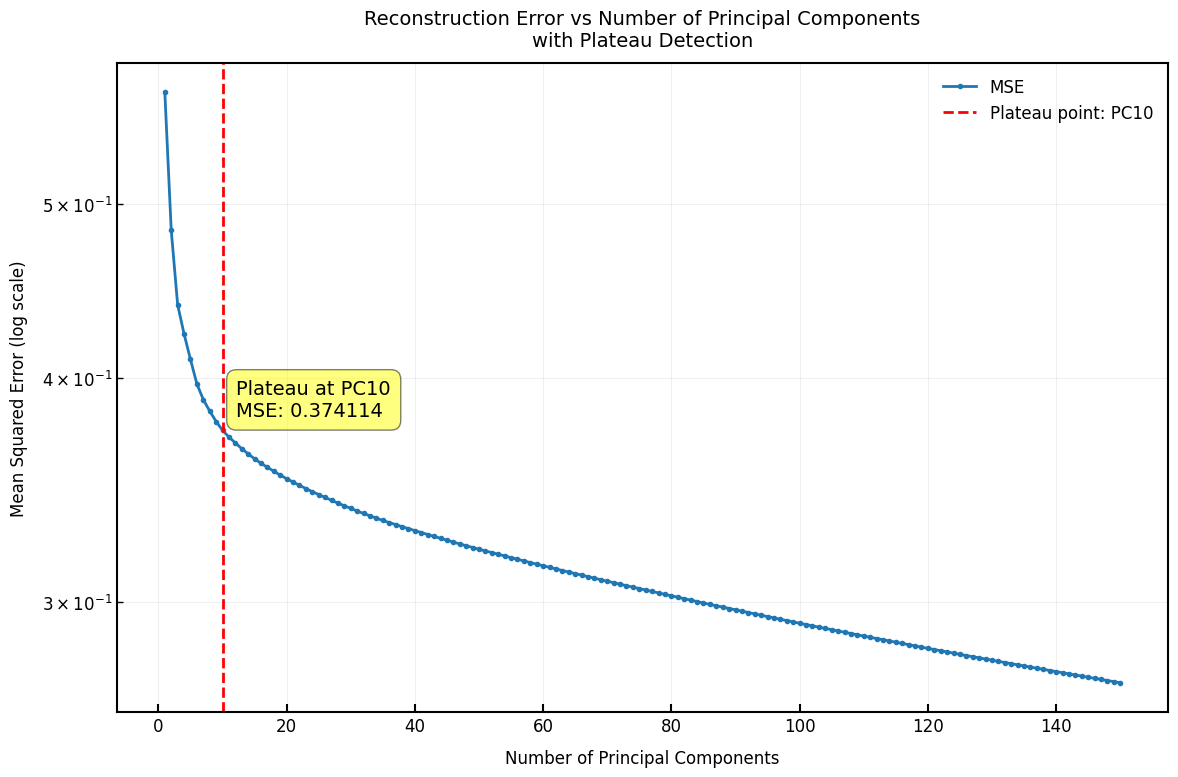


Plateau detected at PC10
MSE at plateau: 0.374114
Rate of change at plateau: 0.87%

Rate of change in first few components:
PC1 to PC2: 16.25%
PC2 to PC3: 9.11%
PC3 to PC4: 3.66%
PC4 to PC5: 3.23%
PC5 to PC6: 3.09%
PC6 to PC7: 1.99%
PC7 to PC8: 1.47%
PC8 to PC9: 1.33%
PC9 to PC10: 1.12%
PC10 to PC11: 0.87%


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Calculate mean of the original data
mean_data = np.average(data_matrix, weights=weights, axis=0)

# Initialize arrays
n_components_range = range(1, 151)
mse_values = np.zeros(len(n_components_range))
batch_size = 1000

# Calculate number of batches
n_samples = data_matrix.shape[0]
n_batches = int(np.ceil(n_samples / batch_size))

for i, n_comp in enumerate(tqdm(n_components_range)):
    total_mse = 0
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, n_samples)
        
        batch_data = data_matrix[start_idx:end_idx]
        batch_scores = (batch_data - mean_data) @ eig_vecs_sorted[:n_comp].T
        batch_reconstruction = mean_data + (batch_scores @ eig_vecs_sorted[:n_comp])
        batch_mse = np.mean((batch_data - batch_reconstruction)**2, axis=1)
        total_mse += np.sum(batch_mse)
    
    mse_values[i] = total_mse / n_samples

# Calculate rate of change
mse_diff = np.diff(mse_values)
mse_rate = np.abs(mse_diff / mse_values[:-1]) * 100  # percentage change

# Find plateau point (where rate of change becomes less than 1%)
threshold = 1  # 1% change
plateau_point = np.where(mse_rate < threshold)[0][0] + 1  # +1 because of diff

# Plot
plt.figure(figsize=(12, 8))

# Main plot with MSE values
plt.plot(n_components_range, mse_values, '-o', markersize=3, label='MSE')

# Add vertical line at plateau point
plt.axvline(x=plateau_point, color='r', linestyle='--', 
            label=f'Plateau point: PC{plateau_point}')

# Add annotation for plateau point
plt.annotate(f'Plateau at PC{plateau_point}\nMSE: {mse_values[plateau_point-1]:.6f}',
            xy=(plateau_point, mse_values[plateau_point-1]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.yscale('log')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Mean Squared Error (log scale)', fontsize=12)
plt.title('Reconstruction Error vs Number of Principal Components\nwith Plateau Detection', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# Print key values
print(f"\nPlateau detected at PC{plateau_point}")
print(f"MSE at plateau: {mse_values[plateau_point-1]:.6f}")
print(f"Rate of change at plateau: {mse_rate[plateau_point-1]:.2f}%")

# Print first few rates of change for context
print("\nRate of change in first few components:")
for i in range(min(10, len(mse_rate))):
    print(f"PC{i+1} to PC{i+2}: {mse_rate[i]:.2f}%")

Plot saved to: figures_publication_corrected/mse_curvature_analysis_pub_style_final_method.png
Plot saved to: figures_publication_corrected/mse_curvature_analysis_pub_style_final_method.pdf


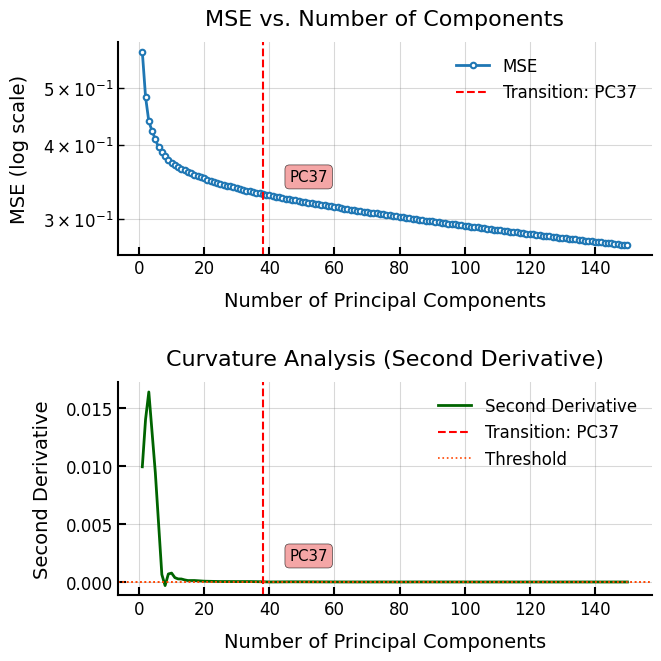


Transition point detected at PC37
MSE at transition: 0.330577
Second derivative at transition: 0.000021


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy.signal import savgol_filter
import os

# --- Matplotlib settings ---
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['axes.labelpad'] = 10.0
plt.rcParams['axes.titlepad'] = 12.0
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.frameon'] = False
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = False 

smoothed_mse = None
first_derivative = None
second_derivative = np.array([]) # Initialize as empty
x_range = np.array([])
transition_point = None
curvature_threshold = 0.0

try:
    if len(mse_values) >= 11: # Condition for original savgol_filter to work
        smoothed_mse = savgol_filter(mse_values, window_length=11, polyorder=3)
        first_derivative = np.gradient(smoothed_mse)
        second_derivative = np.gradient(first_derivative)
    elif len(mse_values) >= 3 : # Minimal for any smoothing/gradient
        print(f"Warning: len(mse_values) is {len(mse_values)}, < 11. Savgol_filter with w=11,p=3 would fail.")
        print("Attempting gradient on raw data (deviation from original method if it errored).")
        # This is a fallback, original might have just errored.
        first_derivative = np.gradient(mse_values)
        second_derivative = np.gradient(first_derivative)
    else:
        print("Warning: mse_values too short for derivative calculations.")

    if len(second_derivative) > 0:
        x_range = np.array(n_components_range)[:len(second_derivative)]
        curvature_threshold = np.std(second_derivative) * 0.01
        potential_indices = np.where(np.abs(second_derivative) < curvature_threshold)[0]
        if len(potential_indices) > 0:
            transition_point = potential_indices[0]
        else:
            print("Warning: No transition point found with current threshold. Original method would error.")
            print("Using fallback: minimum absolute second derivative.")
            if len(second_derivative) > 0:
                transition_point = np.argmin(np.abs(second_derivative))
            else: # Should not be reachable if len(second_derivative) > 0 check passed
                transition_point = 0
    elif len(mse_values) > 0 :
        print("Warning: Second derivative array is effectively empty. Cannot determine transition point reliably.")
        transition_point = 0
        if len(x_range) == 0 and len(n_components_range) > 0 : x_range = np.array(n_components_range) # Plot raw MSE if no derivatives
    else: # mse_values is empty or too short
        print("Error: mse_values is empty or too short. Cannot perform analysis.")
        # Fallback to prevent plotting errors
        if len(mse_values) == 0: mse_values = np.array([0.1]); n_components_range = np.array([1])


except ValueError as e:
    print(f"Error during derivative calculation (likely Savgol or gradient): {e}")
    # transition_point remains None or its last assigned value
except Exception as e:
    print(f"An unexpected error occurred during calculations: {e}")


# Plot
fig, axs = plt.subplots(2, 1, figsize=(7, 7))

# --- Main plot (MSE) ---
ax = axs[0]
ax.plot(n_components_range, mse_values, '-o', markersize=4, markerfacecolor='white', markeredgewidth=1.5, label='MSE')

plot_transition_flag = False
if transition_point is not None and \
   transition_point < len(n_components_range) and \
   transition_point < len(mse_values):
    plot_transition_flag = True

if plot_transition_flag:
    tp_val_x_plot = n_components_range[transition_point]
    tp_label_pc_reported = transition_point # Using index for PC label as per "old method"

    ax.axvline(x=tp_val_x_plot, color='r', linestyle='--', linewidth=1.5,
                label=f'Transition: PC{tp_label_pc_reported}')
    ax.annotate(f'PC{tp_label_pc_reported}',
                xy=(tp_val_x_plot, mse_values[transition_point]),
                xytext=(tp_val_x_plot + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
                        mse_values[transition_point] * (1.1 if ax.get_yscale() == 'log' else 1) + (0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0]) if ax.get_yscale() != 'log' else 0) ),
                bbox=dict(boxstyle='round,pad=0.3', fc='lightcoral', alpha=0.7, lw=0.5),
                fontsize=plt.rcParams['legend.fontsize'] * 0.9)

ax.set_yscale('log')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('MSE (log scale)')
ax.set_title('MSE vs. Number of Components')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.3, color='gray', linewidth=plt.rcParams['grid.linewidth'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# --- Second derivative plot ---
ax = axs[1]
if len(x_range) > 0 and len(second_derivative) > 0 and len(x_range) == len(second_derivative):
    ax.plot(x_range, second_derivative, label='Second Derivative', color='darkgreen')
    if plot_transition_flag and transition_point < len(x_range) and transition_point < len(second_derivative):
        tp_val_x_deriv_plot = x_range[transition_point]
        tp_label_pc_deriv_reported = transition_point

        ax.axvline(x=tp_val_x_deriv_plot, color='r', linestyle='--', linewidth=1.5,
                    label=f'Transition: PC{tp_label_pc_deriv_reported}')
        ax.axhline(y=curvature_threshold, color='orangered', linestyle=':', linewidth=1.2, label='Threshold')
        ax.axhline(y=-curvature_threshold, color='orangered', linestyle=':', linewidth=1.2)
        ax.annotate(f'PC{tp_label_pc_deriv_reported}',
                    xy=(tp_val_x_deriv_plot, second_derivative[transition_point]),
                    xytext=(tp_val_x_deriv_plot + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
                            second_derivative[transition_point] + 0.1 * (ax.get_ylim()[1] - ax.get_ylim()[0])),
                    bbox=dict(boxstyle='round,pad=0.3', fc='lightcoral', alpha=0.7, lw=0.5),
                    fontsize=plt.rcParams['legend.fontsize'] * 0.9)
    elif len(second_derivative) == 0 : # Explicitly handle if second_derivative became empty after checks
        ax.text(0.5, 0.5, "Second derivative data is empty.", ha='center', va='center', transform=ax.transAxes)

else:
    ax.text(0.5, 0.5, "Data for derivative plot is insufficient or mismatched.", ha='center', va='center', transform=ax.transAxes)
    if 'x_range' in locals() and 'second_derivative' in locals(): # Check if they exist before printing len
      print(f"Debug plot: len(x_range)={len(x_range)}, len(second_derivative)={len(second_derivative)}")


ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Second Derivative')
ax.set_title('Curvature Analysis (Second Derivative)')
ax.legend()
ax.grid(True, which="major", ls="-", alpha=0.3, color='gray', linewidth=plt.rcParams['grid.linewidth'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout(pad=1.5, h_pad=2.0)

figures_dir = "figures_publication_corrected" # New directory
os.makedirs(figures_dir, exist_ok=True)
file_base = os.path.join(figures_dir, "mse_curvature_analysis_pub_style_final_method")
plt.savefig(f"{file_base}.png")
print(f"Plot saved to: {file_base}.png")
plt.savefig(f"{file_base}.pdf")
print(f"Plot saved to: {file_base}.pdf")

plt.show()

if plot_transition_flag:
    print(f"\nTransition point detected at PC{transition_point}") # Uses index as PC
    print(f"MSE at transition: {mse_values[transition_point]:.6f}")
    if transition_point < len(second_derivative):
        print(f"Second derivative at transition: {second_derivative[transition_point]:.6f}")
    else:
        print(f"Second derivative at transition: N/A (index {transition_point} out of bounds for second_derivative len {len(second_derivative)})")

else:
    print("\nCould not reliably report transition point values.")

In [ ]:
eig_vals_sorted_37 = eig_vals_sorted[:37]
eig_vecs_sorted_37 = eig_vecs_sorted[:37, :]
principal_components = data_matrix @ eig_vecs_sorted_37.T
PCs_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
PCs_df.head()

/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_17857/3346919097.py:3: RuntimeWarning: divide by zero encountered in matmul
  principal_components = data_matrix @ eig_vecs_sorted_16.T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_17857/3346919097.py:3: RuntimeWarning: overflow encountered in matmul
  principal_components = data_matrix @ eig_vecs_sorted_16.T
/var/folders/kx/t6d2888502v4kp2x_8699l200000gp/T/ipykernel_17857/3346919097.py:3: RuntimeWarning: invalid value encountered in matmul
  principal_components = data_matrix @ eig_vecs_sorted_16.T


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37
0,251.030121,-8.223025,12.334774,20.418015,-11.553961,10.388198,17.611980,-9.610418,1.513344,-3.013389,...,-0.622206,1.775031,-3.484906,1.322063,0.638751,0.796458,-6.541600,0.006214,-1.991251,0.336075
1,258.289398,4.135660,10.678961,-12.468651,0.222864,6.980472,-8.272037,1.107338,-3.061597,-1.875696,...,3.553980,0.887315,-1.810372,1.614961,2.645726,-4.032254,-3.439910,2.148940,-3.146681,1.726181
2,240.893982,17.714851,13.764029,4.757721,3.546074,0.325901,-10.307488,-0.443846,-0.289814,-1.944846,...,-1.225649,-0.336106,2.052163,3.367245,-0.843007,2.415862,1.479093,1.154090,2.924676,-1.689701
3,231.491867,16.888142,-11.555701,4.325901,11.831754,-1.627326,-9.647032,-6.503891,6.757596,9.109939,...,-1.120997,2.531816,-0.686610,-2.017620,0.102170,-0.406191,-6.969715,0.108980,-4.481948,1.252586
4,248.554108,6.649262,18.549929,-6.456899,11.748095,2.089196,0.574363,-7.050735,11.141932,0.381504,...,-0.494581,1.891818,-0.780408,0.502075,3.562065,2.158284,-2.678216,-0.295172,-3.979862,-3.258604


In [15]:
df = pd.concat([metadata_df, PCs_df], axis=1)
df.rename(columns={'filename': 'file_name'}, inplace=True)
df

,gen,family,species,sub_species,common_name,recordist,date,time,country,location,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37
0,Turdinus,Pellorneidae (Ground Babblers and Allies),Turdinus_atrigularis,None,Black-throated Wren-Babbler,Somkiat Pakapinyo (Chai),2019-07-27,06:30,Malaysia,"Danum Valley Field Centre, Danum Valley, Sabah...",...,-0.622206,1.775031,-3.484906,1.322063,0.638751,0.796458,-6.541600,0.006214,-1.991251,0.336075
1,Sipia,Thamnophilidae (Typical Antbirds),Sipia_palliata,None,Magdalena Antbird,Bram Vogels,2021-12-11,08:00,Colombia,"San Francisco, Antioquia",...,3.553980,0.887315,-1.810372,1.614961,2.645726,-4.032254,-3.439910,2.148940,-3.146681,1.726181
2,Eurillas,Pycnonotidae (Bulbuls),Eurillas_virens,erythroptera,Little Greenbul,Étienne Leroy,2020-01-10,12:00,Ivory Coast,"Forêt classée du Mont Tonkoui, Man, Montagnes ...",...,-1.225649,-0.336106,2.052163,3.367245,-0.843007,2.415862,1.479093,1.154090,2.924676,-1.689701
3,Geothlypis,Parulidae (New World Warblers),Geothlypis_tolmiei,None,MacGillivray's Warbler,Bruce Lagerquist,2022-06-13,09:59,United States,"Old Blewitt Pass, Kittitas County, Washington",...,-1.120997,2.531816,-0.686610,-2.017620,0.102170,-0.406191,-6.969715,0.108980,-4.481948,1.252586
4,Lathrotriccus,Tyrannidae (Tyrant Flycatchers),Lathrotriccus_euleri,bolivianus,Euler's Flycatcher,Nick Athanas,2002-06-21,07:00,Ecuador,"El Para, east of Archidona, Napo",...,-0.494581,1.891818,-0.780408,0.502075,3.562065,2.158284,-2.678216,-0.295172,-3.979862,-3.258604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116787,Pellorneum,Pellorneidae (Ground Babblers and Allies),Pellorneum_rostratum,None,White-chested Babbler,Peter Boesman,2017-02-09,06:30,Malaysia,"Deremakot forest reserve, Sabah, Borneo",...,4.178884,-2.158112,-0.698307,0.977932,-1.227305,0.238194,-2.634782,-1.925951,-3.567895,-2.698180
116788,Prinia,Cisticolidae (Cisticolas and Allies),Prinia_erythroptera,None,Red-winged Prinia,Peter Boesman,2022-06-16,07:30,Uganda,Murchison falls National Park,...,10.960299,-1.154381,1.325883,2.778542,-6.716774,0.768144,-7.315687,-1.881280,-4.572136,-0.268028
116789,Cyanocitta,"Corvidae (Crows, Jays, and Magpies)",Cyanocitta_stelleri,None,Steller's Jay,manuel Grosselet,2011-01-16,11:00 AM,Mexico,El Tepozan park,...,1.019962,-0.995967,-0.768690,-1.871938,-2.824692,-1.296935,3.733105,-0.125560,0.048850,2.041843
116790,Remiz,Remizidae (Penduline-Tits),Remiz_coronatus,stoliczkae,White-crowned Penduline Tit,Frank Lambert,2013-05-15,17:20,Mongolia,UB Ponds (sewage works) Ulaanbaatar,...,-3.843956,-2.160261,-1.514563,-4.051815,5.579091,1.633355,0.832540,0.658810,2.083338,2.460406


In [16]:
num_nan = df.isna().sum()
print(f"Number of rows with NaNs: {num_nan}")

Number of rows with NaNs: gen                0
family             0
species            0
sub_species    89741
common_name        0
recordist          0
date               0
time               0
country            0
location           0
lat             3952
lng             3936
bird               0
file_name          0
weights            0
PC1                0
PC2                0
PC3                0
PC4                0
PC5                0
PC6                0
PC7                0
PC8                0
PC9                0
PC10               0
PC11               0
PC12               0
PC13               0
PC14               0
PC15               0
PC16               0
PC17               0
PC18               0
PC19               0
PC20               0
PC21               0
PC22               0
PC23               0
PC24               0
PC25               0
PC26               0
PC27               0
PC28               0
PC29               0
PC30               0
PC31               0
PC32    

In [ ]:
from sklearn.preprocessing import MinMaxScaler
PCs_scaled = StandardScaler().fit_transform(PCs_df)

In [17]:
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=1, n_components=2, metric='euclidean')
X_umap = reducer.fit_transform(PCs_scaled)

df['UMAP 1'] = X_umap[:, 0]
df['UMAP 2'] = X_umap[:, 1]

/Users/quentinbacquele/Desktop/PhD/analysis/mps/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/quentinbacquele/Desktop/PhD/analysis/mps/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=1, n_components=3, metric='euclidean')
X_umap = reducer.fit_transform(PCs_scaled)

df['UMAP3D 1'] = X_umap[:, 0]
df['UMAP3D 2'] = X_umap[:, 1]
df['UMAP3D 3'] = X_umap[:, 2]

/Users/quentinbacquele/Desktop/PhD/analysis/mps/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/quentinbacquele/Desktop/PhD/analysis/mps/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
#df.to_csv('../data/traits_data.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import umap.umap_ as umap
import seaborn as sns
import matplotlib.colors as mcolors

df['family'] = df['family'].astype('category')

# Create a custom color palette with distinct colors
unique_families = df['family'].unique()

def generate_many_distinct_colors(n):
    """
    Generate distinct colors by combining multiple qualitative palettes
    """
    palettes = [
        sns.color_palette("Set1", n_colors=9),
        sns.color_palette("Set2", n_colors=8),
        sns.color_palette("Set3", n_colors=12),
        sns.color_palette("Paired", n_colors=12),
        sns.color_palette("Dark2", n_colors=8),
        sns.color_palette("Accent", n_colors=8),
        sns.color_palette("tab20", n_colors=20),
        sns.color_palette("tab20b", n_colors=20),
        sns.color_palette("tab20c", n_colors=20),
        sns.color_palette("husl", n_colors=25)
    ]
    
    all_colors = []
    for palette in palettes:
        hex_colors = [mcolors.rgb2hex(c) for c in palette]
        all_colors.extend(hex_colors)
    
    all_colors = list(dict.fromkeys(all_colors))
    
    while len(all_colors) < n:
        for color in all_colors[:]:
            if len(all_colors) >= n:
                break
            rgb = mcolors.to_rgb(color)
            modified_rgb = tuple(min(1.0, max(0.0, v + np.random.uniform(-0.2, 0.2))) for v in rgb)
            all_colors.append(mcolors.rgb2hex(modified_rgb))
    
    np.random.shuffle(all_colors)
    return all_colors[:n]

# Generate colors and create color map
custom_palette = generate_many_distinct_colors(len(unique_families))
color_map = dict(zip(unique_families, custom_palette))

def plot_scatter(df_plot, x_col, y_col, color_map, 
                 color_col='family', title=''):
    """
    Plots df_plot[x_col] vs. df_plot[y_col] colored by 'family'.
    """
    plt.figure(figsize=(10, 8))
    for fam, color in color_map.items():
        subset = df_plot[df_plot[color_col] == fam]
        plt.scatter(
            subset[x_col],
            subset[y_col],
            color=color,
            alpha=1.0,  
            s=15  
        )
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# List of PC columns
pc_cols = [f"PC{i}" for i in range(1, 21)]

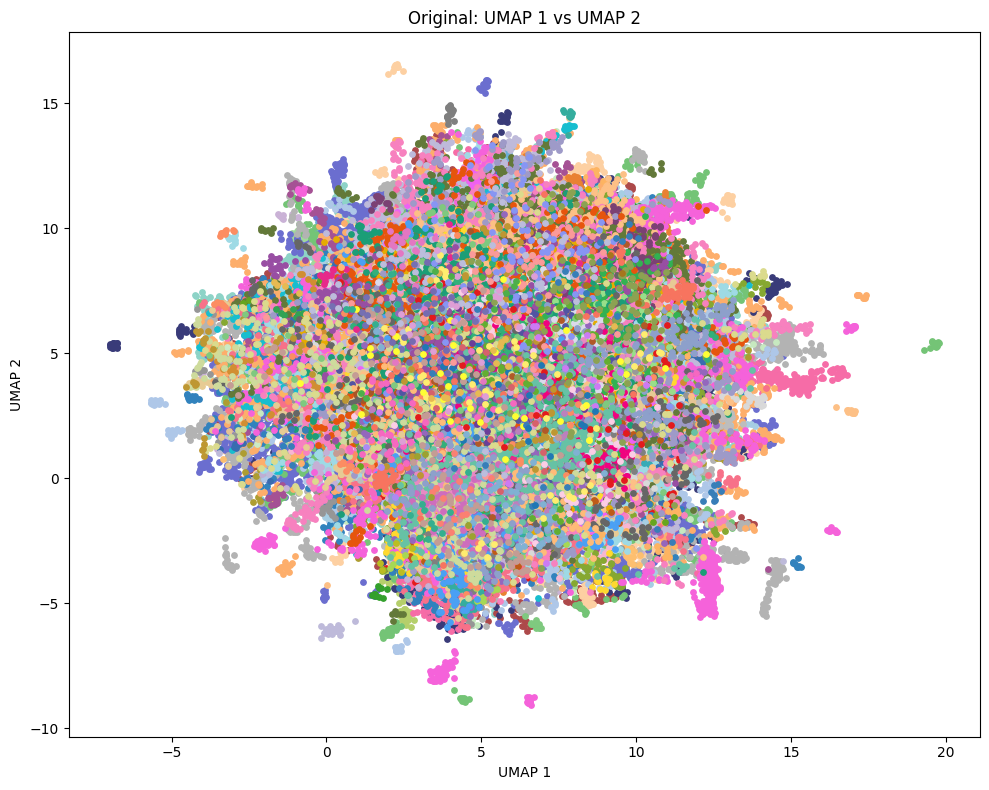

In [20]:
# Plot 1: UMAP 1 vs. UMAP 2
plot_scatter(
    df,
    'UMAP 1',
    'UMAP 2',
    color_map,
    title="Original: UMAP 1 vs UMAP 2"
)

Plot saved to: figures/umap_family_density_unified_cb.png
Plot saved to: figures/umap_family_density_unified_cb.pdf


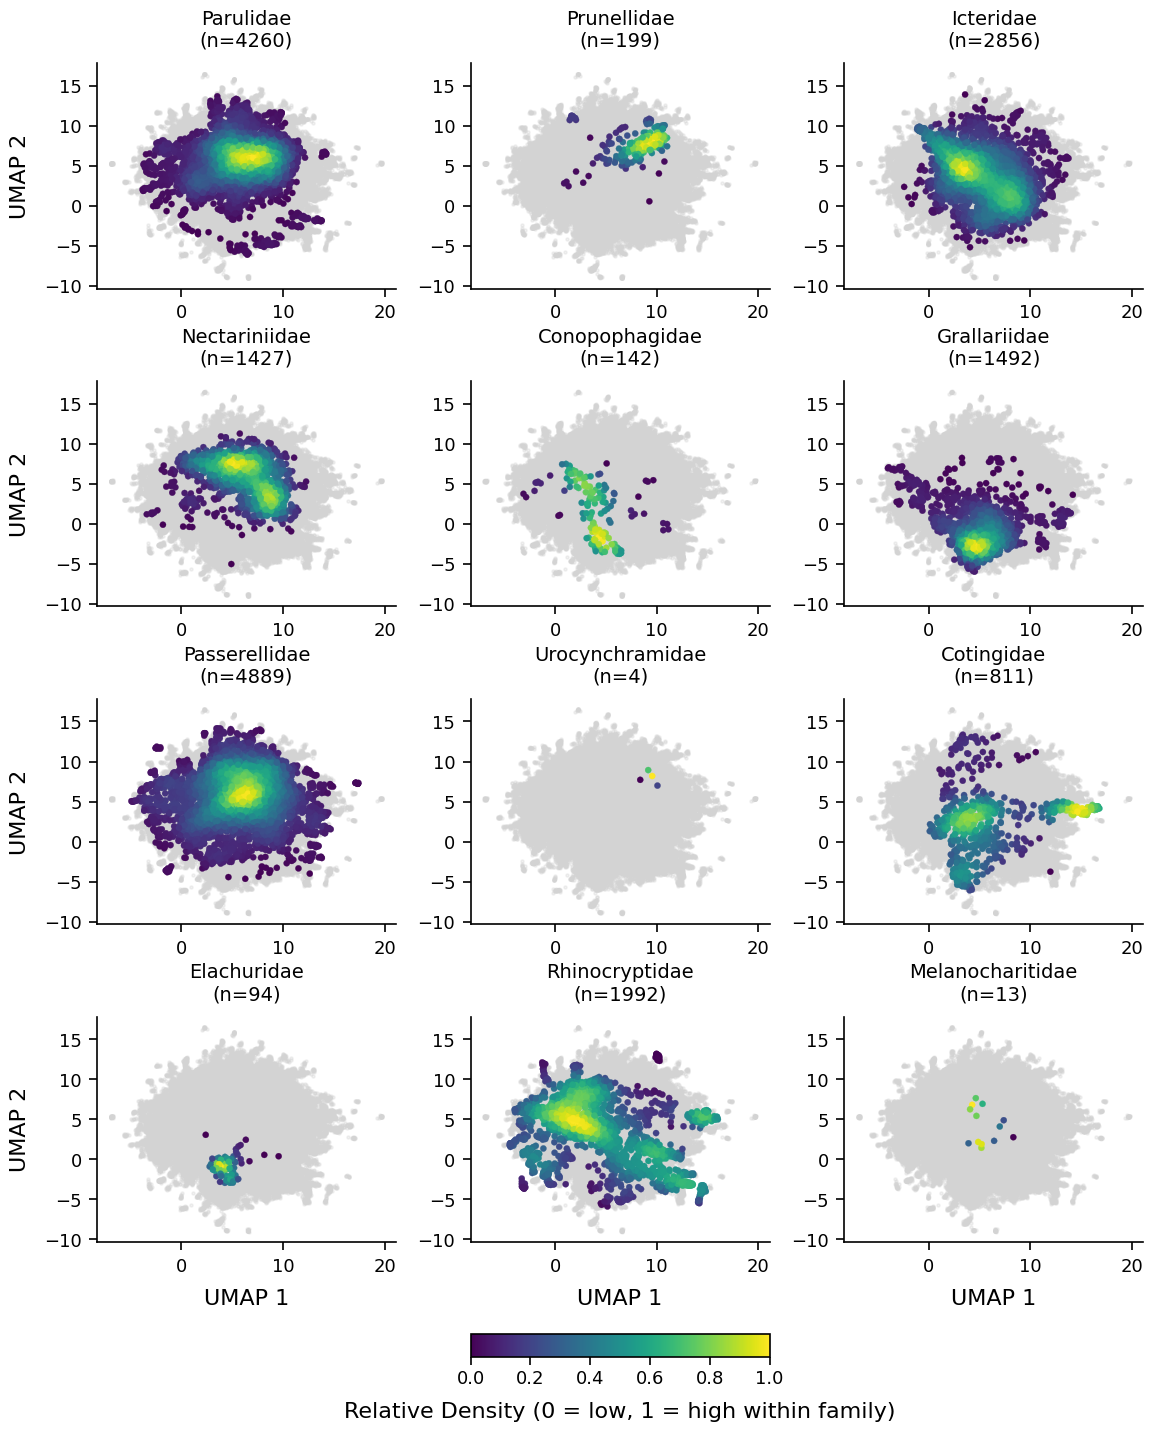

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import pandas as pd

def plot_umap_subplots_by_family_density_pub(df, x_col='UMAP 1', y_col='UMAP 2', output_filename_base="umap_family_density_unified_cb"):
    """
    Creates publication-quality UMAP subplots with a unified colorbar:
      - Single colorbar at the bottom for all subplots
      - Larger font sizes for publication
      - Global density normalization across all families
      - Outward-pointing ticks
      - Light grey background points with colored density overlay
    """

    # --- Enhanced Publication Quality Settings ---
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['legend.fontsize'] = 13
    plt.rcParams['figure.titlesize'] = 18

    plt.rcParams['lines.linewidth'] = 1.5
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6

    plt.rcParams['axes.labelpad'] = 10.0
    plt.rcParams['axes.titlepad'] = 12.0

    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'

    plt.rcParams['savefig.dpi'] = 600
    plt.rcParams['savefig.bbox'] = 'tight'
    # --- End Settings ---

    target_families = [
        'Parulidae (New World Warblers)', 'Prunellidae (Accentors)', 'Icteridae (Troupials and Allies)',
        'Nectariniidae (Sunbirds and Spiderhunters)', 'Conopophagidae (Gnateaters)', 'Grallariidae (Antpittas)',
        'Passerellidae (New World Sparrows)', 'Urocynchramidae (Przevalski\'s Pinktail)', 'Cotingidae (Cotingas)',
        'Elachuridae (Spotted Elachura)', 'Rhinocryptidae (Tapaculos)', 'Melanocharitidae (Berrypeckers and Longbills)'
    ]


    df['family'] = df['family'].astype('category')

    # --- Compute densities with individual normalization to 0-1 ---
    family_data = {}
    
    for target_family in target_families:
        subset = df[df['family'] == target_family]
        x_coords = subset[x_col].values
        y_coords = subset[y_col].values
        
        density_values = []
        if len(x_coords) > 1:
            try:
                xy = np.vstack([x_coords, y_coords])
                kde = gaussian_kde(xy)
                density_values = kde(xy)
                # Normalize to 0-1 for this family
                d_min, d_max = density_values.min(), density_values.max()
                if d_max > d_min:
                    density_values = (density_values - d_min) / (d_max - d_min)
                else:
                    density_values = np.ones_like(density_values) * 0.5
            except (np.linalg.LinAlgError, ValueError) as e:
                print(f"KDE failed for {target_family}, using uniform density.")
                density_values = np.ones_like(x_coords) * 0.5
        elif len(x_coords) == 1:
            density_values = np.array([0.5])
        
        family_data[target_family] = {
            'x': x_coords,
            'y': y_coords,
            'density': density_values,
            'n': len(subset)
        }
    
    # Use 0-1 normalization for all plots
    norm = Normalize(vmin=0, vmax=1)


    n_rows, n_cols = 4, 3
    fig = plt.figure(figsize=(n_cols * 4.5, n_rows * 4 + 0.8))
    
    # Create grid with space for colorbar at bottom
    gs = fig.add_gridspec(n_rows + 1, n_cols, height_ratios=[1, 1, 1, 1, 0.1], 
                          hspace=0.5, wspace=0.25)
    
    axes = []
    for row in range(n_rows):
        for col in range(n_cols):
            axes.append(fig.add_subplot(gs[row, col]))

    # Plot each family
    for i, target_family in enumerate(target_families):
        ax = axes[i]

        # Background: all points in light grey
        ax.scatter(df[x_col], df[y_col],
                   color='lightgrey', s=5, alpha=0.3, rasterized=True)

        # Foreground: target family with density coloring
        data = family_data[target_family]
        if len(data['x']) > 0:
            sc = ax.scatter(data['x'], data['y'], 
                          c=data['density'], 
                          cmap='viridis', 
                          s=20,
                          linewidth=0.2, 
                          norm=norm,  # Shared normalization
                          rasterized=True)

        # Extract only Latin name (remove English name in parentheses)
        latin_name = target_family.split(' (')[0]
        ax.set_title(f"{latin_name}\n(n={data['n']})", fontsize=14)

        # Axis labels only on outer plots
        if i // n_cols == n_rows - 1:
            ax.set_xlabel(x_col)
        if i % n_cols == 0:
            ax.set_ylabel(y_col)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', pad=5)

    # Hide unused subplots
    for j in range(len(target_families), len(axes)):
        axes[j].set_visible(False)


    cbar_ax = fig.add_subplot(gs[-1, 1]) 
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Relative Density (0 = low, 1 = high within family)', fontsize=16, labelpad=10)
    cbar.ax.tick_params(labelsize=13)


    # --- Save figures ---
    figures_dir = "figures"
    try:
        os.makedirs(figures_dir, exist_ok=True)
        
        file_path_png = os.path.join(figures_dir, f"{output_filename_base}.png")
        plt.savefig(file_path_png)
        print(f"Plot saved to: {file_path_png}")

        file_path_pdf = os.path.join(figures_dir, f"{output_filename_base}.pdf")
        plt.savefig(file_path_pdf)
        print(f"Plot saved to: {file_path_pdf}")

    except Exception as e:
        print(f"Error saving figures: {e}")

    plt.show()

# Execute the function
plot_umap_subplots_by_family_density_pub(df)

Directory 'figures' ensured.
Plot saved to: figures/umap_family_species_density.png
Plot saved to: figures/umap_family_species_density.pdf


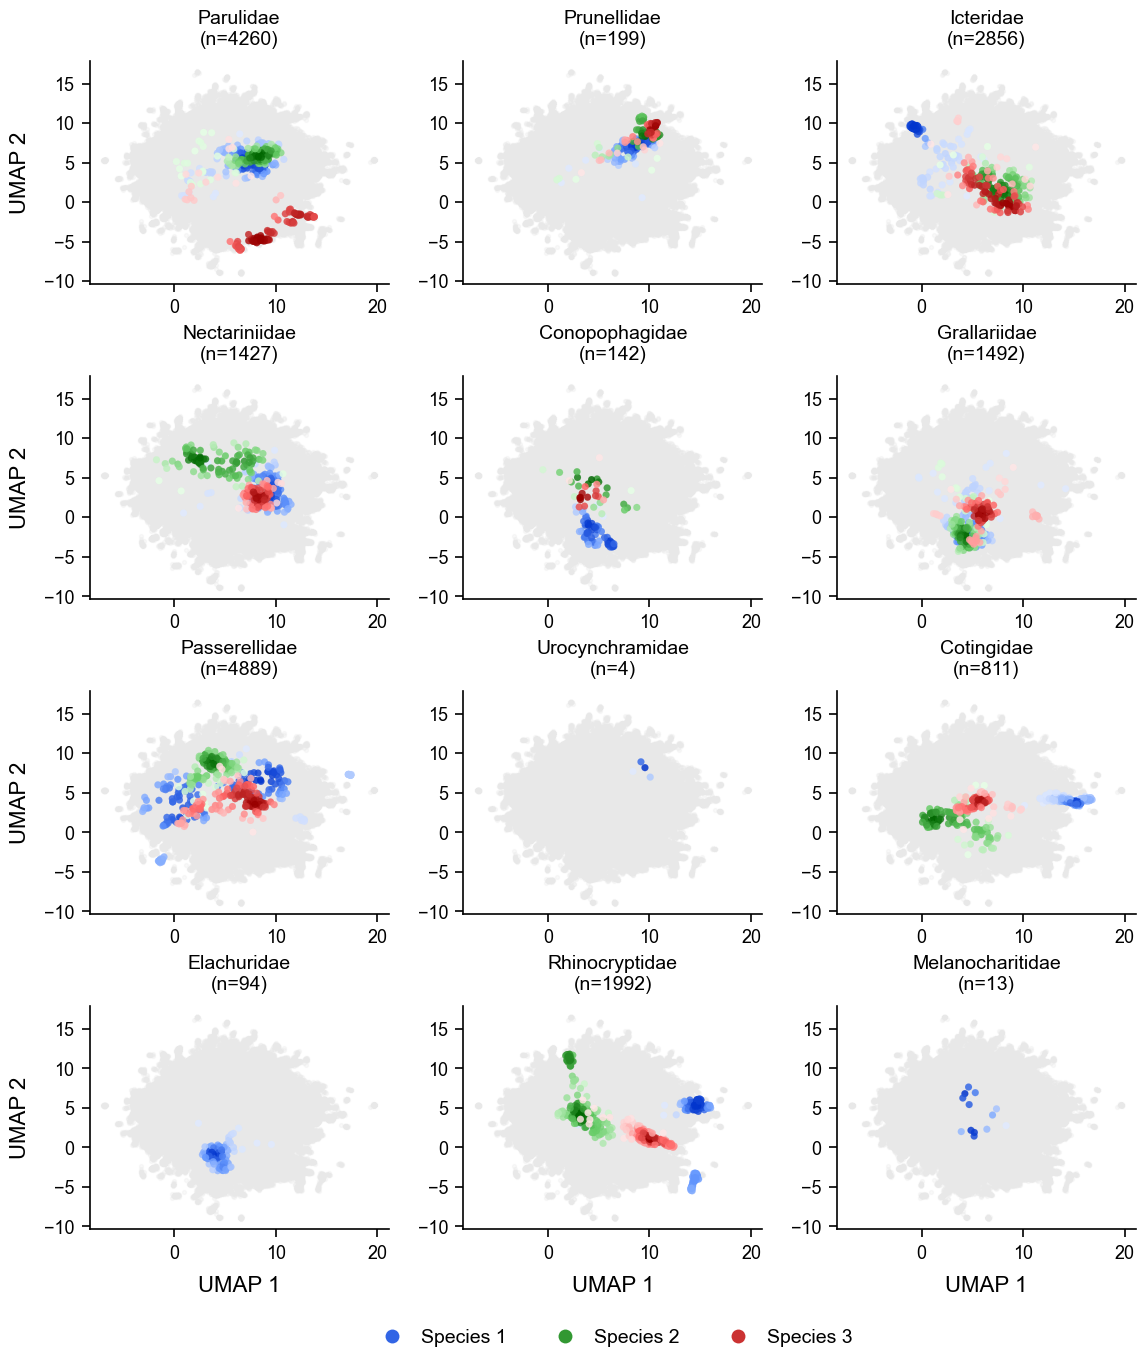

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import os

def plot_umap_subplots_by_family_species_density_pub(df, x_col='UMAP 1', y_col='UMAP 2', species_col='species',
                                                  output_filename_base="umap_family_species_density"):
    """
    Creates publication-quality subplots for specific families, coloring density by up to 3 species per family.
    Features a single common legend at the bottom with generic species labels.
    """

    # --- Enhanced Publication Quality Settings ---
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 18

    plt.rcParams['lines.linewidth'] = 1.5
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6

    plt.rcParams['axes.labelpad'] = 10.0
    plt.rcParams['axes.titlepad'] = 12.0

    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'

    plt.rcParams['savefig.dpi'] = 600
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['legend.frameon'] = False
    # --- End Settings ---

    # Define custom color maps
    custom_blue = LinearSegmentedColormap.from_list('custom_blue', ['#e0eaff', '#6699ff', '#0033cc'])
    custom_green = LinearSegmentedColormap.from_list('custom_green', ['#e6ffe6', '#66cc66', '#006600'])
    custom_red = LinearSegmentedColormap.from_list('custom_red', ['#ffe6e6', '#ff6666', '#990000'])
    
    colormaps = [custom_blue, custom_green, custom_red]
    max_species_to_plot = 3

    target_families = [
        'Parulidae (New World Warblers)', 'Prunellidae (Accentors)', 'Icteridae (Troupials and Allies)',
        'Nectariniidae (Sunbirds and Spiderhunters)', 'Conopophagidae (Gnateaters)', 'Grallariidae (Antpittas)',
        'Passerellidae (New World Sparrows)', 'Urocynchramidae (Przevalski\'s Pinktail)', 'Cotingidae (Cotingas)',
        'Elachuridae (Spotted Elachura)', 'Rhinocryptidae (Tapaculos)', 'Melanocharitidae (Berrypeckers and Longbills)'
    ]

    # --- Input Validation ---
    if not isinstance(df, pd.DataFrame):
        print("Error: 'df' is not a pandas DataFrame.")
        return
    for col in ['family', species_col, x_col, y_col]:
        if col not in df.columns:
            print(f"Error: Required column '{col}' not found in DataFrame.")
            return
    # --- End Validation ---

    df['family'] = df['family'].astype('category')

    n_rows, n_cols = 4, 3
    
    # Create figure with space for legend at bottom
    fig = plt.figure(figsize=(n_cols * 4.5, n_rows * 4 + 0.8))
    gs = fig.add_gridspec(n_rows + 1, n_cols, height_ratios=[1, 1, 1, 1, 0.15], 
                          hspace=0.5, wspace=0.25)
    
    axes = []
    for row in range(n_rows):
        for col in range(n_cols):
            axes.append(fig.add_subplot(gs[row, col]))

    for i_ax, target_family in enumerate(target_families):
        ax = axes[i_ax]

        # Background: all points in light grey
        ax.scatter(df[x_col], df[y_col],
                   color='#e8e8e8', s=8, alpha=0.25, rasterized=True, zorder=1)

        family_subset = df[df['family'] == target_family].copy()
        n_samples_family = len(family_subset)

        # Get top 3 species by count
        if not family_subset.empty:
            species_counts = family_subset[species_col].value_counts()
            top_species_in_family = species_counts.nlargest(max_species_to_plot).index.tolist()
        else:
            top_species_in_family = []

        for i_species, species_name in enumerate(top_species_in_family):
            species_subset = family_subset[family_subset[species_col] == species_name]
            x_species = species_subset[x_col].values
            y_species = species_subset[y_col].values

            if len(x_species) == 0:
                continue

            density_species_normalized = np.ones_like(x_species, dtype=float)
            if len(x_species) > 1:
                try:
                    xy_species = np.vstack([x_species, y_species])
                    kde_species = gaussian_kde(xy_species)
                    density_species = kde_species(xy_species)
                    
                    min_d, max_d = density_species.min(), density_species.max()
                    if max_d > min_d:
                        density_species_normalized = (density_species - min_d) / (max_d - min_d)
                    else:
                        density_species_normalized = np.ones_like(density_species) * 0.7
                except (np.linalg.LinAlgError, ValueError) as e:
                    print(f"KDE failed for {species_name} in {target_family}. Using uniform density.")
                    density_species_normalized = np.ones_like(x_species) * 0.7

            cmap_species = colormaps[i_species % len(colormaps)]
            ax.scatter(x_species, y_species,
                       c=density_species_normalized,
                       cmap=cmap_species,
                       s=25,
                       linewidth=0.1, alpha=0.85, rasterized=True, zorder=i_species + 2)

        # Extract only Latin name (remove English name in parentheses)
        latin_name = target_family.split(' (')[0]
        ax.set_title(f"{latin_name}\n(n={n_samples_family})", fontsize=14)

        # Axis labels only on outer plots
        if i_ax // n_cols == n_rows - 1:
            ax.set_xlabel(x_col)
        if i_ax % n_cols == 0:
            ax.set_ylabel(y_col)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', pad=5)

    # Hide unused subplots
    for j in range(len(target_families), len(axes)):
        axes[j].set_visible(False)

    # --- Add common legend at bottom ---
    legend_ax = fig.add_subplot(gs[-1, :])
    legend_ax.axis('off')
    
    # Create generic legend handles
    legend_handles = []
    species_labels = ['Species 1', 'Species 2', 'Species 3']
    for i in range(3):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                        label=species_labels[i],
                                        markerfacecolor=colormaps[i](0.75),
                                        markersize=10, markeredgewidth=0))
    
    legend_ax.legend(handles=legend_handles, loc='center', ncol=3, 
                    fontsize=14, frameon=False,
                    columnspacing=2.0, handletextpad=0.5)
    # --- End legend ---

    # --- Save figures ---
    figures_dir = "figures"
    try:
        os.makedirs(figures_dir, exist_ok=True)
        print(f"Directory '{figures_dir}' ensured.")
        
        file_path_png = os.path.join(figures_dir, f"{output_filename_base}.png")
        plt.savefig(file_path_png)
        print(f"Plot saved to: {file_path_png}")
        
        file_path_pdf = os.path.join(figures_dir, f"{output_filename_base}.pdf")
        plt.savefig(file_path_pdf)
        print(f"Plot saved to: {file_path_pdf}")
        
    except Exception as e:
        print(f"Error saving figures: {e}")

    plt.show()

# Execute the function
plot_umap_subplots_by_family_species_density_pub(df)